In [227]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [228]:
#!pip install tqdm

In [229]:
#df0 = pd.read_csv('../spreadsheets/rlhf_20250104_6.csv') # 0.9, 0.95, 1.0, 0.99, 0.99, 8000
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # Best 0.01, 0.85, 0.01, 0.95, 0.95, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv') # 0.05, 0.99, 0.5, 0.99, 0.997, 6000, 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv') # 0.05, 0.99, 0.5, 0.99, 0.997, 6000
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv') # 0.01, 0.95, 1.0, 0.997, 0.995, 26000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_12rl.csv') # 0.01, 0.85, 0.01, 0.95, 0.95, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_15rl.csv') # 0.05, 0.95, 1.0, 0.999, 0.995, 12000, 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_19rl.csv') # 0.01, 0.95, 1.0, 0.997, 0.995, 26000, 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_24rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_25rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_26rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_157nlp.csv') # 0.7, 0.95, 0.5, 0.999, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_157nlpgate.csv') # 0.25, 0.95, 0.01, 0.997, 0.999, 14000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_29rl.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000, 0.9, 0.95, 1.0, 0.99, 0.99, 8000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_30rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_32rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_33rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_35rl.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_large_36rl.csv')

In [230]:
df0['ask'] = df0['close'] * df0['volume']/(df0['close'] + df0['open'])

In [231]:
df0['bid'] = df0['open'] * df0['volume']/(df0['close'] + df0['open'])

In [232]:
df0.head()

,Unnamed: 0,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid
0,0,0.534500,0.536400,0.497462,0.489006,0.511300,0,0.521800,7.898190e+06,0.488548,...,0.502460,0.497686,0,0,go_long,go_short,go_long,5.984069,3.901615e+06,3.996576e+06
1,1,0.182200,0.183400,0.180516,0.178809,0.181900,0,0.183300,1.294002e+06,0.178788,...,0.181480,0.180829,0,1,go_short,go_short,go_long,-5.372316,6.489482e+05,6.450538e+05
2,2,0.025338,0.025348,0.025601,0.026033,0.024288,1,0.024401,1.798130e+09,0.026236,...,0.025259,0.025356,1,0,go_long,go_short,go_long,4.147186,8.821279e+08,9.160016e+08
3,3,1.626000,1.647500,1.592690,1.571094,1.623200,0,1.623900,1.004819e+08,1.571272,...,1.612120,1.603329,0,0,go_long,go_short,go_long,4.228221,5.020850e+07,5.027343e+07
4,4,14.530000,14.538000,14.086798,13.912075,14.125000,0,14.230000,7.359380e+04,13.866320,...,14.172400,14.174857,0,0,go_long,go_long,go_long,1.886275,3.641307e+04,3.718073e+04


In [233]:
df0.drop(['Unnamed: 0'], axis=1, inplace=True)

In [234]:
df0['nlpreds'].value_counts()

nlpreds
go_long     2170
go_short     335
Name: count, dtype: int64

In [235]:
#action_mapping = {"go_long": 0, "go_short": 1}

In [236]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [237]:
train_data = df0 #prep_data(df0)

In [238]:
train_data.head(2)

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid
0,0.5345,0.5364,0.497462,0.489006,0.5113,0,0.5218,7898190.4,0.488548,0,...,0.50246,0.497686,0,0,go_long,go_short,go_long,5.984069,3.901615e+06,3.996576e+06
1,0.1822,0.1834,0.180516,0.178809,0.1819,0,0.1833,1294002.0,0.178788,0,...,0.18148,0.180829,0,1,go_short,go_short,go_long,-5.372316,6.489482e+05,6.450538e+05


In [239]:
new_cols = ['open', 'high', 'ema-26', 'ema-12', 'low', \
            'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', \
            'sma-compare', 'is_short'
        ]

In [240]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
train_data["action_num"] = train_data["nlpreds"].map(action_mapping)

In [241]:
# Define RL parameters
#states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
states = train_data[new_cols].values
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [242]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [243]:
# Hyperparameters [0.25, 0.95, 1.0, 0.99, 0.99, 10000], [0.9, 0.95, 1.0, 0.99, 0.99, 8000], [0.7, 0.75, 1.0, 0.97, 0.999, 28000]
# [0.05, 0.95, 1.0, 0.999, 0.995, 12000], [1, 0.95, 0.1, 0.96, 0.96, 12000], [0.25, 0.99, 0.01, 0.997, 0.99, 8000]
# [1, 0.75, 0.05, 0.999, 0.999, 10000], [0.01, 0.85, 0.01, 0.95, 0.95, 12000], [0.01, 0.99, 1.0, 0.95, 0.99, 16000], [0.05, 0.99, 0.5, 0.99, 0.997, 6000]
# [0.25, 0.95, 0.01, 0.997, 0.999, 14000], [0.01, 0.95, 1.0, 0.997, 0.995, 26000], [0.9, 0.9, 0.005, 0.95, 0.999, 10000]
# [0.7, 0.95, 0.5, 0.999, 0.99, 16000], [0.005, 0.75, 0.1, 0.95, 0.999, 12000], [0.001, 0.75, 1.0, 0.99, 0.99, 30000]
'''
alpha = 1
gamma = 0.95
epsilon = 0.1
min_epsilon = 0.96
decay_rate = 0.96
n_episodes = 12000
'''
alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = 0.9, 0.99, 0.5, 0.995, 0.95, 12000 #0.9, 0.9, 0.005, 0.95, 0.999, 10000 # 0.25, 0.95, 0.01, 0.997, 0.999, 14000



In [244]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('large_state_to_index.npy', state_to_index)


In [245]:
# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action

evaluating results per episode ...:   0%|          | 29/12000 [00:00<01:28, 135.55it/s]

Episode 0/12000 - Total Reward: -1835.2951134899984, Epsilon: 0.995


evaluating results per episode ...:   4%|▎         | 426/12000 [00:03<01:39, 115.99it/s]

Episode 400/12000 - Total Reward: 852.0057614099973, Epsilon: 0.995


evaluating results per episode ...:   7%|▋         | 835/12000 [00:06<01:34, 118.44it/s]

Episode 800/12000 - Total Reward: 280.17657613999995, Epsilon: 0.995


evaluating results per episode ...:  10%|█         | 1228/12000 [00:10<01:35, 113.20it/s]

Episode 1200/12000 - Total Reward: 1823.63685390999, Epsilon: 0.995


evaluating results per episode ...:  14%|█▎        | 1624/12000 [00:13<01:38, 105.36it/s]

Episode 1600/12000 - Total Reward: 1345.9424857899885, Epsilon: 0.995


evaluating results per episode ...:  17%|█▋        | 2016/12000 [00:16<01:10, 142.60it/s]

Episode 2000/12000 - Total Reward: 864.7446128499993, Epsilon: 0.995


evaluating results per episode ...:  20%|██        | 2416/12000 [00:19<01:08, 140.12it/s]

Episode 2400/12000 - Total Reward: -231.97929989000824, Epsilon: 0.995


evaluating results per episode ...:  24%|██▎       | 2829/12000 [00:22<01:02, 146.40it/s]

Episode 2800/12000 - Total Reward: 751.9923586699996, Epsilon: 0.995


evaluating results per episode ...:  27%|██▋       | 3224/12000 [00:25<01:19, 109.71it/s]

Episode 3200/12000 - Total Reward: 242.26799653999956, Epsilon: 0.995


evaluating results per episode ...:  30%|███       | 3625/12000 [00:28<00:56, 147.84it/s]

Episode 3600/12000 - Total Reward: 807.8062644899995, Epsilon: 0.995


evaluating results per episode ...:  34%|███▎      | 4020/12000 [00:31<01:05, 122.15it/s]

Episode 4000/12000 - Total Reward: -2688.2483341599973, Epsilon: 0.995


evaluating results per episode ...:  37%|███▋      | 4424/12000 [00:34<01:02, 120.72it/s]

Episode 4400/12000 - Total Reward: -3455.9789148099926, Epsilon: 0.995


evaluating results per episode ...:  40%|████      | 4817/12000 [00:38<00:55, 129.48it/s]

Episode 4800/12000 - Total Reward: -50.75038054999999, Epsilon: 0.995


evaluating results per episode ...:  44%|████▎     | 5233/12000 [00:41<01:01, 109.88it/s]

Episode 5200/12000 - Total Reward: 866.2725286099977, Epsilon: 0.995


evaluating results per episode ...:  47%|████▋     | 5625/12000 [00:44<00:43, 147.26it/s]

Episode 5600/12000 - Total Reward: 768.8727558999996, Epsilon: 0.995


evaluating results per episode ...:  50%|█████     | 6041/12000 [00:47<00:45, 131.65it/s]

Episode 6000/12000 - Total Reward: -3807.4726350099922, Epsilon: 0.995


evaluating results per episode ...:  54%|█████▎    | 6436/12000 [00:50<00:45, 122.19it/s]

Episode 6400/12000 - Total Reward: 315.12580264999997, Epsilon: 0.995


evaluating results per episode ...:  57%|█████▋    | 6842/12000 [00:54<00:44, 116.96it/s]

Episode 6800/12000 - Total Reward: -805.9718484500055, Epsilon: 0.995


evaluating results per episode ...:  60%|██████    | 7235/12000 [00:56<00:37, 127.27it/s]

Episode 7200/12000 - Total Reward: 535.6648818999998, Epsilon: 0.995


evaluating results per episode ...:  64%|██████▎   | 7638/12000 [01:00<00:37, 115.73it/s]

Episode 7600/12000 - Total Reward: 704.6821948799997, Epsilon: 0.995


evaluating results per episode ...:  67%|██████▋   | 8016/12000 [01:03<00:29, 133.21it/s]

Episode 8000/12000 - Total Reward: -3252.7384952199945, Epsilon: 0.995


evaluating results per episode ...:  70%|███████   | 8417/12000 [01:06<00:25, 142.68it/s]

Episode 8400/12000 - Total Reward: 901.4209333599996, Epsilon: 0.995


evaluating results per episode ...:  73%|███████▎  | 8819/12000 [01:09<00:23, 136.86it/s]

Episode 8800/12000 - Total Reward: -4789.159913159991, Epsilon: 0.995


evaluating results per episode ...:  77%|███████▋  | 9222/12000 [01:12<00:18, 149.66it/s]

Episode 9200/12000 - Total Reward: 345.62314412000046, Epsilon: 0.995


evaluating results per episode ...:  80%|████████  | 9624/12000 [01:15<00:18, 128.03it/s]

Episode 9600/12000 - Total Reward: 857.1544242299993, Epsilon: 0.995


evaluating results per episode ...:  83%|████████▎ | 10017/12000 [01:18<00:17, 110.49it/s]

Episode 10000/12000 - Total Reward: 403.63535174000015, Epsilon: 0.995


evaluating results per episode ...:  87%|████████▋ | 10433/12000 [01:21<00:11, 140.49it/s]

Episode 10400/12000 - Total Reward: 808.5150297099993, Epsilon: 0.995


evaluating results per episode ...:  90%|█████████ | 10823/12000 [01:24<00:09, 124.90it/s]

Episode 10800/12000 - Total Reward: -405.1587050100038, Epsilon: 0.995


evaluating results per episode ...:  94%|█████████▎| 11220/12000 [01:27<00:05, 141.87it/s]

Episode 11200/12000 - Total Reward: -2887.095053679999, Epsilon: 0.995


evaluating results per episode ...:  97%|█████████▋| 11629/12000 [01:31<00:02, 139.65it/s]

Episode 11600/12000 - Total Reward: -1188.0431196700083, Epsilon: 0.995


evaluating results per episode ...: 100%|██████████| 12000/12000 [01:33<00:00, 128.04it/s]


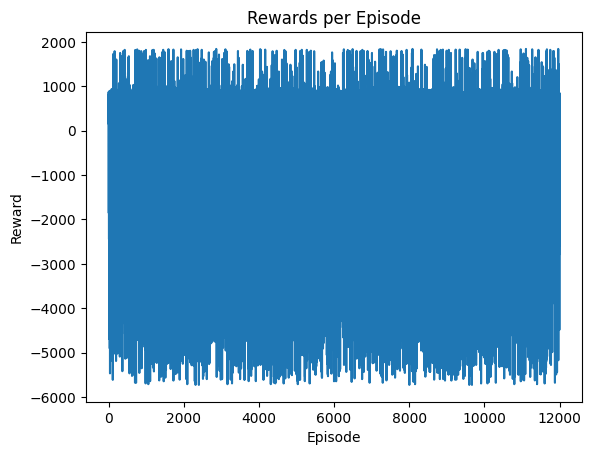

In [246]:

# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("large_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()



In [247]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="large_state_to_index.npy")
loaded_qtable = load_q_table(file_path="large_q_table.npy")

In [248]:
#state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
#                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
#                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])

def prep_state(
                open: float, high: float, ema_26: float, ema_12: float, low: float,
                mean_grad_hist: float, close: float, volume: float, sma_25: float,
                long_jcrosk: float, short_kdj: float, sma_compare: int, is_short: int,
            ):
    state = np.array([[open, high, ema_26, ema_12, low, mean_grad_hist, close, volume, sma_25, long_jcrosk, short_kdj, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state


In [249]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action

In [250]:
# Predict an entire range
for idx, row in train_data.iterrows():
    state = row[['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'is_short']].values
    action = predict_action(state, q_table, state_to_index, action_mapping)
    train_data.loc[idx, "predicted_action"] = action

In [251]:
# Predict an entire range
def predict_range(filename: str) -> DataFrame:
    df = pd.read_csv(filename)
    df['action_num'] = train_data['action_num']
    for idx, row in df.iterrows():
        state = row[['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'is_short']].values
        action = predict_action(state, q_table, state_to_index, action_mapping)
        df.loc[idx, "predicted_action"] = action
    return df

### Change this to predict a different file

In [252]:
#train_data = predict_range('../spreadsheets/rlhf_large_1072.csv')

In [253]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       1913
do_nothing     306
go_short       286
Name: count, dtype: int64

In [254]:
m = train_data[((train_data['predicted_action'] == 'go_short') & (train_data['predicted_action'] == 'do_nothing')) & (train_data['reward'] > 0)]
m['is_short'].value_counts()

Series([], Name: count, dtype: int64)

In [255]:
longs = dict(m['is_short'].value_counts().items()).get(0)
print(longs)
shorts = dict(m['is_short'].value_counts().items()).get(1)
print(shorts)

None
None


In [256]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)
print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/2504
Current Predicted Reward: -5.37231572
Current Actual Reward: -5.37231572
Processed state 100/2504
Current Predicted Reward: 755.0075233999997
Current Actual Reward: 1080.5410523199998
Processed state 200/2504
Current Predicted Reward: 1985.1191084399986
Current Actual Reward: 2310.652637359999
Processed state 300/2504
Current Predicted Reward: 2905.4600049699984
Current Actual Reward: 3550.5854586099986
Processed state 400/2504
Current Predicted Reward: 3313.634864129998
Current Actual Reward: 4798.93971933
Processed state 500/2504
Current Predicted Reward: 3808.0988761799986
Current Actual Reward: 6041.297320040003
Processed state 600/2504
Current Predicted Reward: 4212.977199929998
Current Actual Reward: 7138.83253316
Processed state 700/2504
Current Predicted Reward: 4040.288288069997
Current Actual Reward: 6326.089369459994
Processed state 800/2504
Current Predicted Reward: 3498.2383278599973
Current Actual Reward: 4634.717703039992
Processed state 900/2504
C

In [257]:
# Accuracy

correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 67.70%


In [258]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1657  247  266]
 [ 256   39   40]
 [   0    0    0]]


In [259]:
def accuracy(conf_matrix, n_states):
    # True Positives (TP): Diagonal elements of the confusion matrix
    TP = conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[2][2]
    # **True Positives**: 16 (class 0), 0 (class 1), 0 (class 2)
    return TP/n_states

In [260]:
#print(accuracy(cp, n_states=n_states))

In [261]:
df0['predicted_action'].value_counts()

predicted_action
go_long       1913
do_nothing     306
go_short       286
Name: count, dtype: int64

In [262]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == f'{action}') & (train_data['is_short'] == is_short)]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    return {
        'counts': counts.get(is_short),
        'total': total_reward,
        'winrate': f'{wins * 100 / (losses + wins):.2f}%'
    }

In [263]:
print(action_reward('go_long', 0))

{'counts': 1644, 'total': 2684.337451819996, 'winrate': '48.72%'}


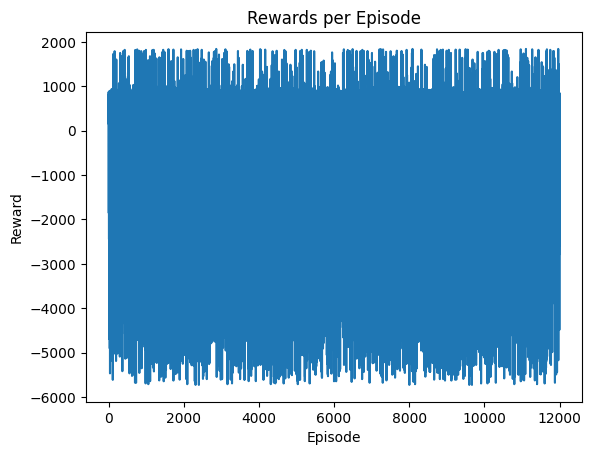

In [264]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [265]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate) # default min_epsilon = 0.01

    return q_table, rewards_per_episode


In [266]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    # Add tqdm for progress visualization
    for state_index in tqdm(range(n_states), desc="Evaluating States"):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [267]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

'''

'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [268]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [269]:
'''
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}
# 1500, 4000,6000, 8000, 9000, 10000, 11000, 
# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > best_cumulative_pred_reward:\n            best_cumulative_pred_reward = cumulative_pred_reward\n        